# **Customer Churn Analysis**

Customer churn analysis is the process of investigating why customers stop using a product or service, aiming to identify patterns and reasons for customer attrition. In this project, the dataset is sourced from an online e-commerce platform and contains customer related information such as Tenure, Warehouse-to-Home distance, Number of Devices Registered, Preferred Order Category, Satisfaction Score, Marital Status, Number of Addresses, Complaint History, Days Since Last Order, and Cashback Amount, along with the churn status indicating wheter a customer has left or remained.
the main objective is to create a machine learning model that can predict the likelihood of a customer churning, enabling the business to implement targeted retention strategies, and ultimately increase customer loyalty

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
precision_recall_curve, auc, roc_curve, ConfusionMatrixDisplay)
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss


In [3]:
df_churn = pd.read_csv('/content/drive/MyDrive/data machine learning/data_ecommerce_customer_churn.csv')

# Handling Duplicated Data



In this part, the dataset is examined to identify and remove duplicate items
that may occur due to repeated entries or data collection errors. duplicated data can lead to bias in model training, inaccurate statistical analysis, and reduced model performance

In [4]:
df_churn.head() #first five rows of the dataframe

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


In [5]:
len(df_churn) #total number of rows in the dataframe

3941

In [6]:
len(df_churn.drop_duplicates()) / len(df_churn) #check whether there is any duplicates

0.8297386450139559

In [7]:
duplicates = df_churn[df_churn.duplicated()] #get the number of duplicates data
len(duplicates) #total number of duplicates

671

In [8]:
df_churn = df_churn.drop_duplicates() #drop all duplicates in the dataframe

In [9]:
len(df_churn) - len(df_churn.drop_duplicates()) #check if there is still any duplicates

0

In [10]:
len(df_churn.drop_duplicates()) / len(df_churn) # check if there is still any duplicates

1.0

In [11]:
len(df_churn) #total number of rows in the dataframe

3270

# Outlier Handling

Outlier Handling is the process of detecting and, if needed, treating data points that are significantly different from the rest of the dataset. these unsual data can distort statistical analysis and reduce the performance of machine learning models

In [12]:
#import module for statistical functions
import scipy.stats as stats

In [13]:
features  = list(df_churn)[:-1] #select all columns except the target column
features

['Tenure',
 'WarehouseToHome',
 'NumberOfDeviceRegistered',
 'PreferedOrderCat',
 'SatisfactionScore',
 'MaritalStatus',
 'NumberOfAddress',
 'Complain',
 'DaySinceLastOrder',
 'CashbackAmount']

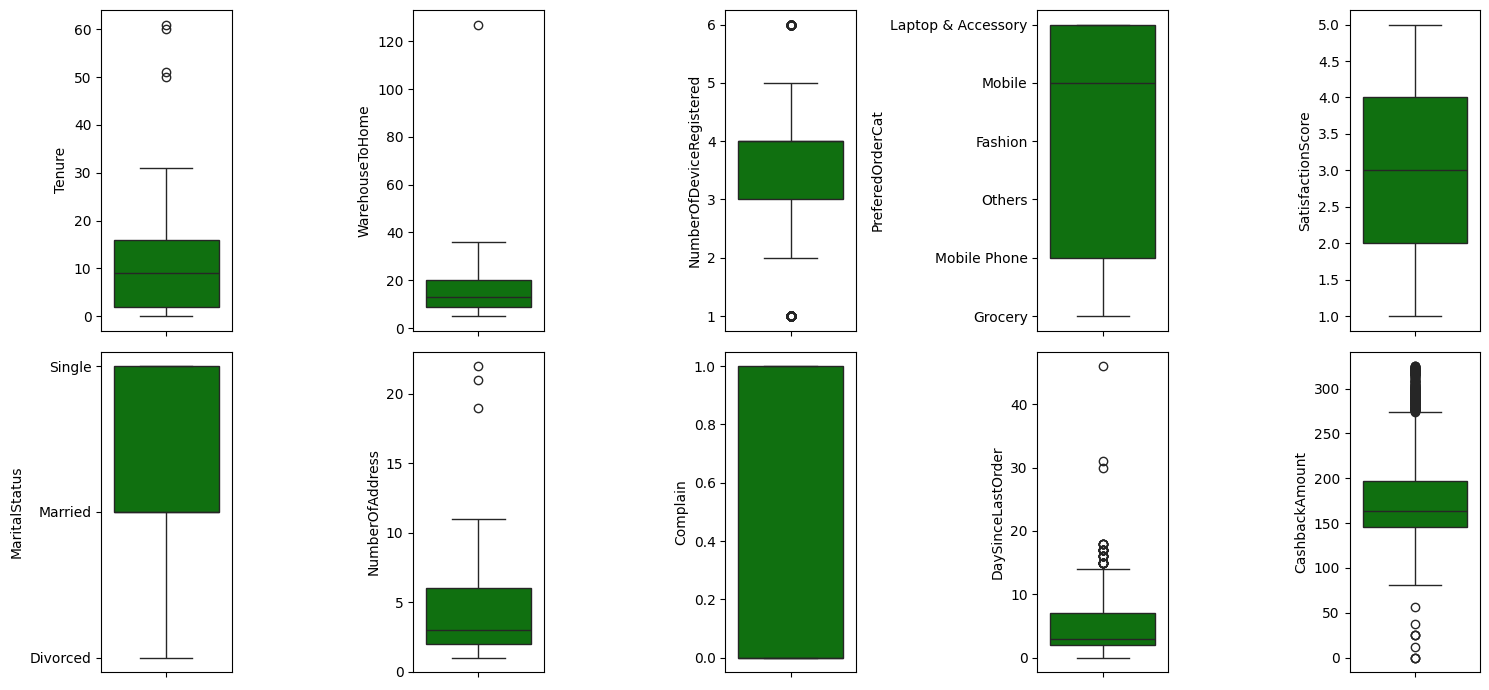

In [14]:
#create Q-Q plots
plt.figure(figsize=(15, 7)) #create a figure with a size of 15 inches wide and 7 inches tall
for i in range(0, len(features)): #loops through all the features
    plt.subplot(2, 5, i+1) #create a grid layout for the plots: 2 rows and 5 columns
    sns.boxplot(y=features[i],data=df_churn,color='green') #create a green boxplot for the specified column in features, using data from the dataframe
    plt.tight_layout() #adjusts subplot spacing

In [15]:
df_churn.head() #first five rows of the dataframe

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


In [16]:
def domain_aware_outlier_handling(df): #Handle outliers based on e-commerce business logic
  df_clean = df.copy()

  df_clean.loc[df_clean['Tenure'] <= 0, 'Tenure'] = df_clean['Tenure'].median() # Tenure: Keep high values (loyalty), fix impossible values

  upper_limit = df_clean['WarehouseToHome'].quantile(0.99) #WarehouseToHome: Cap extreme distances (likely data errors)
  df_clean['WarehouseToHome'] = df_clean['WarehouseToHome'].clip(upper=upper_limit)

  df_clean['NumberOfDeviceRegistered'] = df_clean['NumberOfDeviceRegistered'].clip(upper=10) #NumberOfDeviceRegistered: Keep high values (engagement), cap extremes

  df_clean.loc[df_clean['CashbackAmount'] < 0, 'CashbackAmount'] = 0 #CashbackAmount: Keep high values (VIP treatment), fix negatives

  df_clean['DaySinceLastOrder'] = df_clean['DaySinceLastOrder'].clip(upper=365) #DaySinceLastOrder: Cap at 1 year (beyond that is definitely churned)

  df_clean['SatisfactionScore'] = df_clean['SatisfactionScore'].clip(1, 5) #SatisfactionScore: Ensure valid range

  return df_clean

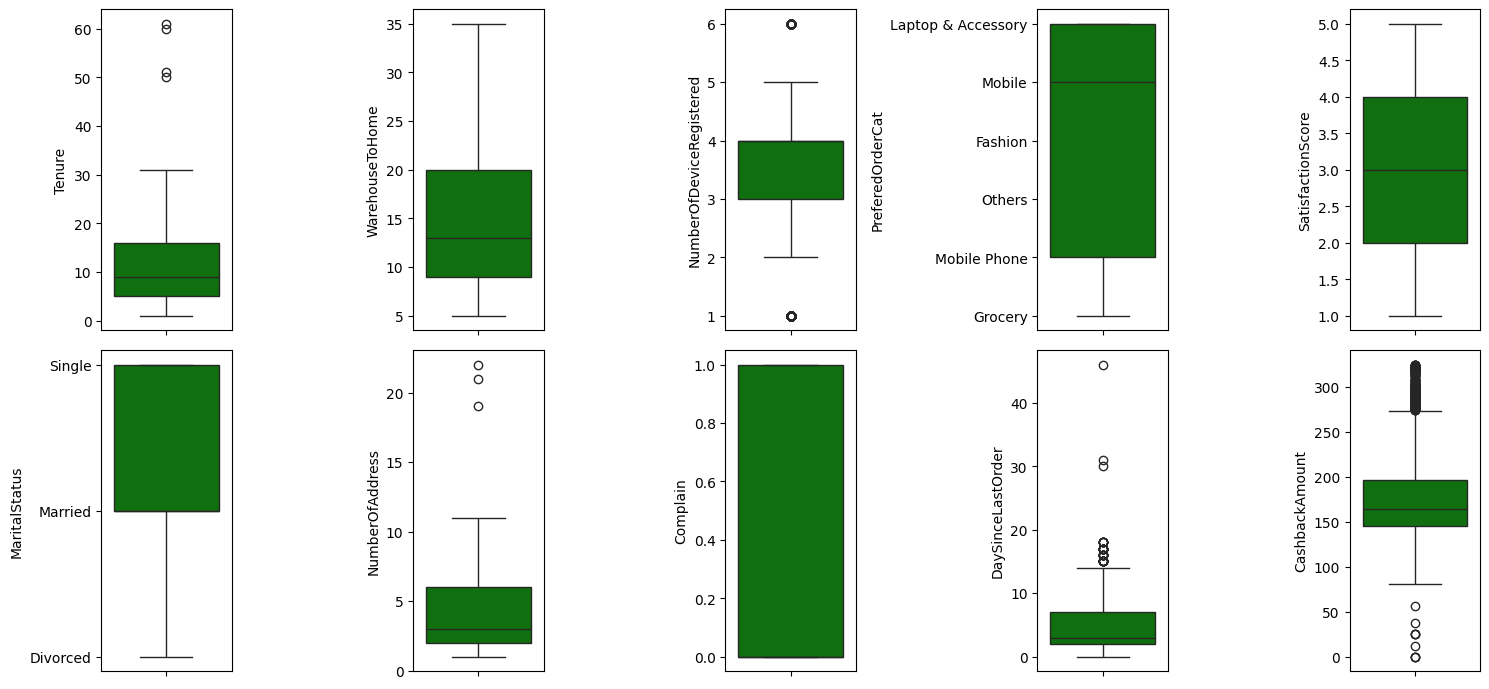

In [17]:
# Apply the outlier handling function to your dataset
df_churn = domain_aware_outlier_handling(df_churn)

# Now re-plot after cleaning
plt.figure(figsize=(15, 7))
for i in range(len(features)):
    plt.subplot(2, 5, i+1)  # adjust rows/cols as needed
    sns.boxplot(y=features[i], data=df_churn, color='green')
plt.tight_layout()

# Missing Value Handling

In this part, the dataset is examined to identify and handle missing values that may occur due to incomplete entries, optional fields, or system logging errors. Missing value can reduce statistical power, introducing bias, and potentially leading to inaccurate results.  

In [18]:
df_churn.head() #shows the first five rows of the dataframe

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


In [19]:
df_churn.isna().sum() #count the number of missing values in the dataframe

,0
Tenure,160
WarehouseToHome,135
NumberOfDeviceRegistered,0
PreferedOrderCat,0
SatisfactionScore,0
MaritalStatus,0
NumberOfAddress,0
Complain,0
DaySinceLastOrder,181
CashbackAmount,0


In [20]:
df_churn.columns #return all the column names of the dataframe

Index(['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered',
       'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus',
       'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount',
       'Churn'],
      dtype='object')

In [21]:
for column in df_churn.columns: #loop through all the columns in the dataframe
    print(f"============= {column} =================") #print the column names
    display(df_churn[column].value_counts(dropna=False)) #display the counts of each value appears in one column
    print()

============= Tenure =================


,count
Tenure,
9.0,421
1.0,400
NaN,160
8.0,151
4.0,130
10.0,128
5.0,123
7.0,123
3.0,118



============= WarehouseToHome =================


,count
WarehouseToHome,
9.0,310
8.0,266
7.0,256
6.0,187
14.0,181
15.0,167
16.0,162
10.0,159
13.0,142



============= NumberOfDeviceRegistered =================


,count
NumberOfDeviceRegistered,
4,1396
3,992
5,493
2,163
1,137
6,89



============= PreferedOrderCat =================


,count
PreferedOrderCat,
Laptop & Accessory,1213
Mobile Phone,725
Fashion,484
Mobile,458
Grocery,241
Others,149



============= SatisfactionScore =================


,count
SatisfactionScore,
3,932
1,707
5,635
4,604
2,392



============= MaritalStatus =================


,count
MaritalStatus,
Married,1686
Single,1008
Divorced,576



============= NumberOfAddress =================


,count
NumberOfAddress,
2,809
3,723
4,331
5,329
1,225
6,221
8,169
7,145
9,137



============= Complain =================


,count
Complain,
0,2349
1,921



============= DaySinceLastOrder =================


,count
DaySinceLastOrder,
3.0,516
2.0,461
1.0,356
8.0,326
0.0,286
4.0,260
7.0,253
NaN,181
9.0,173



============= CashbackAmount =================


,count
CashbackAmount,
149.36,6
148.42,6
188.47,6
152.28,5
134.52,5
...,...
154.32,1
197.15,1
230.02,1



============= Churn =================


,count
Churn,
0,2736
1,534


since the columns with missing values are numeric, we impute them using each column's median

In [22]:
100 * df_churn['Tenure'].isna().sum() / len(df_churn) #computes the percentage of missing values in the Tenure column

np.float64(4.892966360856269)

In [23]:
100 * df_churn['WarehouseToHome'].isna().sum() / len(df_churn) #computes the percentage of missing values in WarehouseToHome column

np.float64(4.128440366972477)

In [24]:
100 * df_churn['DaySinceLastOrder'].isna().sum() / len(df_churn) #computes the percentage of missing values in the DaySinceLastOrder column

np.float64(5.535168195718654)

because the percentage of missing values in each column is below 20%, we impute rather than drop, given the skewed distributions, we use median imputation

In [25]:
from sklearn.model_selection import train_test_split
# Split first, then preprocess
X = df_churn.drop(columns='Churn')
y = df_churn['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
# Calculate statistics ONLY from training data
median_tenure_train = X_train['Tenure'].median()
median_tenure_train

9.0

In [27]:
# Apply to both train and test using training statistics
X_train['Tenure'].fillna(median_tenure_train, inplace=True)
X_test['Tenure'].fillna(median_tenure_train, inplace=True)

In [28]:
# Calculate statistics ONLY from training data
median_WarehouseToHome_train = X_train['WarehouseToHome'].median()
median_WarehouseToHome_train

13.0

In [29]:
# Apply to both train and test using training statistics
X_train['WarehouseToHome'].fillna(median_WarehouseToHome_train, inplace=True)
X_test['WarehouseToHome'].fillna(median_WarehouseToHome_train, inplace=True)

In [30]:
median_DaySinceLastOrder_train = X_train['DaySinceLastOrder'].median()
median_DaySinceLastOrder_train

3.0

In [31]:
# Apply to both train and test using training statistics
X_train['DaySinceLastOrder'].fillna(median_DaySinceLastOrder_train, inplace=True)
X_test['DaySinceLastOrder'].fillna(median_DaySinceLastOrder_train, inplace=True)

In [32]:
df_churn.loc[:, 'Tenure'] = df_churn['Tenure'].fillna(median_tenure_train)
df_churn.loc[:, 'WarehouseToHome'] = df_churn['WarehouseToHome'].fillna(median_WarehouseToHome_train)
df_churn.loc[:, 'DaySinceLastOrder'] = df_churn['DaySinceLastOrder'].fillna(median_DaySinceLastOrder_train)

In [33]:
df_churn.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,3.0,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


In [34]:
df_churn.isna().sum()

,0
Tenure,0
WarehouseToHome,0
NumberOfDeviceRegistered,0
PreferedOrderCat,0
SatisfactionScore,0
MaritalStatus,0
NumberOfAddress,0
Complain,0
DaySinceLastOrder,0
CashbackAmount,0


# Hyperparameter Tuning

## Random Forest



In [35]:
df_churn.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,3.0,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


In [36]:
df_churn.columns

Index(['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered',
       'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus',
       'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount',
       'Churn'],
      dtype='object')

In [37]:
# define random forest classifier model
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)

In [38]:
%%time
# using random search CV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def create_preprocessing_pipeline():
    categorical_features = ['PreferedOrderCat', 'MaritalStatus']
    numerical_features = [col for col in X_train.columns if col not in categorical_features]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features),
        ]
    )
    return preprocessor

preprocessor = create_preprocessing_pipeline()

# Create a pipeline with the preprocessor and the Random Forest classifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=42))])

parameters = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': [None, 'balanced'] # Handle imbalance
}

rf_clf_randomcv = RandomizedSearchCV(pipeline, parameters, cv=5,
                                     scoring='recall', n_iter=10)

# Fit the RandomizedSearchCV with the original DataFrame
rf_clf_randomcv.fit(X_train, y_train)

CPU times: user 1min, sys: 87.7 ms, total: 1min
Wall time: 1min 2s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['Tenure',
                                                                                'WarehouseToHome',
                                                                                'NumberOfDeviceRegistered',
                                                                                'SatisfactionScore',
                                                                                'NumberOfAddress',
                                                                                'Complain',
                                                                                'DaySinceLastOrder',
                                                                                'CashbackAmount']),
                                                                              ('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['PreferedOrderCat',
                                                                                'Marit...
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__class_weight': [None,
                                                                     'balanced'],
                                        'classifier__max_depth': [10, 20, 30,
                                                                  None],
                                        'classifier__max_features': ['sqrt',
                                                                     'log2',
                                                                     None],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [100, 200,
                                                                     300,
                                                                     500]},
                   scoring='recall')

In [39]:
# results of RandomSearchCV
cv_result = pd.DataFrame(rf_clf_randomcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
3,"{'classifier__n_estimators': 100, 'classifier_...",0.669850,1
5,"{'classifier__n_estimators': 100, 'classifier_...",0.669850,1
1,"{'classifier__n_estimators': 200, 'classifier_...",0.653379,3
2,"{'classifier__n_estimators': 200, 'classifier_...",0.637018,4
0,"{'classifier__n_estimators': 200, 'classifier_...",0.594829,5
8,"{'classifier__n_estimators': 200, 'classifier_...",0.583174,6
4,"{'classifier__n_estimators': 100, 'classifier_...",0.515376,7
6,"{'classifier__n_estimators': 300, 'classifier_...",0.498851,8
7,"{'classifier__n_estimators': 500, 'classifier_...",0.456717,9
9,"{'classifier__n_estimators': 500, 'classifier_...",0.356060,10


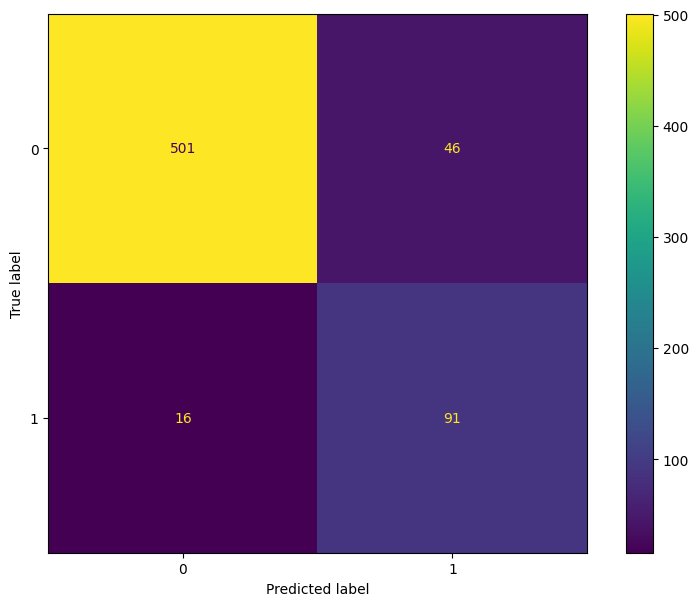

In [40]:
# the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_pred = rf_clf_randomcv.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=rf_clf_randomcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf_clf_randomcv.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

In [41]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix
import pandas as pd

def comprehensive_model_evaluation(model, X_test, y_test, model_name="Model"):
  """Complete evaluation with business context"""
  # Predictions
  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)[:, 1]
  print(f"{'='*50}")
  print(f"{model_name} EVALUATION RESULTS")
  print(f"{'='*50}")

 # 1. Classification Report
  print("\n1. CLASSIFICATION METRICS:")
  print(classification_report(y_test, y_pred))

# 2. ROC-AUC Score
  roc_auc = roc_auc_score(y_test, y_prob)
  print(f"\n2. ROC-AUC SCORE: {roc_auc:.4f}")

# 3. Precision-Recall AUC
  precision, recall, _ = precision_recall_curve(y_test, y_prob)
  pr_auc = auc(recall, precision)
  print(f"3. PR-AUC SCORE: {pr_auc:.4f}")

  # 4. Confusion Matrix Analysis
  cm = confusion_matrix(y_test, y_pred)
  tn,fp, fn, tp = cm.ravel()

  print(f"\n4. CONFUSION MATRIX BREAKDOWN:")
  print(f"  True Positives (TP): {tp}")
  print(f"  True Negatives (TN): {tn}")
  print(f"  False Positives (FP): {fp}")
  print(f"  False Negatives (FN): {fn}")

  # 5. Business Impact Calculation
  retention_cost_per_customer = 50 # Cost to run retention campaign
  customer_ltv = 500 # Customer lifetime value

  retention_campaign_cost = (tp + fp) * retention_cost_per_customer
  revenue_saved = tp * customer_ltv
  revenue_lost = fn * customer_ltv
  net_business_impact = revenue_saved - retention_campaign_cost

  print(f"\n5. BUSINESS IMPACT ANALYSIS:")
  print(f" Retention campaign cost: ${retention_campaign_cost:,}")
  print(f" Revenue saved (correctly identified churners): ${revenue_saved:,}")
  print(f" Revenue lost (missed churners): ${revenue_lost:,}")
  print(f" Net business impact: ${net_business_impact:,}")
  print(f" ROI: {(net_business_impact/retention_campaign_cost)*100:.1f}%")

  # 6. Feature Importance (if available)
  if hasattr(model, 'feature_importances_'):
    feature_imp = pd.DataFrame({
      'feature': X_test.columns,
      'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\n6. TOP 10 FEATURE IMPORTANCE:")
    for i, (_, row) in enumerate(feature_imp.head(10).iterrows()):
      print(f" {i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")
  return {
  'roc_auc': roc_auc,
  'pr_auc': pr_auc,
  'net_impact': net_business_impact,
  'confusion_matrix': cm
}

In [42]:
# Random Forest tuned with RandomizedSearchCV
classification_report_rf = comprehensive_model_evaluation(
    rf_clf_randomcv.best_estimator_, X_test, y_test, model_name="Random Forest"
)
print(classification_report_rf)

Random Forest EVALUATION RESULTS

1. CLASSIFICATION METRICS:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       547
           1       0.66      0.85      0.75       107

    accuracy                           0.91       654
   macro avg       0.82      0.88      0.84       654
weighted avg       0.92      0.91      0.91       654


2. ROC-AUC SCORE: 0.9463
3. PR-AUC SCORE: 0.6910

4. CONFUSION MATRIX BREAKDOWN:
  True Positives (TP): 91
  True Negatives (TN): 501
  False Positives (FP): 46
  False Negatives (FN): 16

5. BUSINESS IMPACT ANALYSIS:
 Retention campaign cost: $6,850
 Revenue saved (correctly identified churners): $45,500
 Revenue lost (missed churners): $8,000
 Net business impact: $38,650
 ROI: 564.2%
{'roc_auc': np.float64(0.9462659536298245), 'pr_auc': np.float64(0.6910010892901819), 'net_impact': np.int64(38650), 'confusion_matrix': array([[501,  46],
       [ 16,  91]])}


In [43]:
n_negatives = y[y==0].shape[0]

n_positives = y[y==1].shape[0]

In [44]:
def predict(model, test_data, threshold=0.5):
    return (model.predict_proba(test_data)[:, 1] >= threshold).astype(int)

In [45]:
#create a function to create a random forest pipeline
def create_random_forest_pipeline(hyperparams):
    class_weight = {0: n_negatives, 1: n_positives}
    preprocessor = create_preprocessing_pipeline()
    classifier = RandomForestClassifier(**hyperparams,
                                        class_weight=class_weight,
                                        random_state=42)
    rf_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
    return rf_pipeline

hyperparams = {"n_estimators": 150, "max_depth": 12, "max_features": "log2"}
rf_pipeline = create_random_forest_pipeline(hyperparams)


rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'Complain',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 2736, 1: 534},
                                        max_depth=12, max_features='log2',
                                        n_estimators=150, random_state=42))])

In [46]:
# Estimate probability on train and test dataset
train_probs = rf_pipeline.predict_proba(X_train)
test_probs = rf_pipeline.predict_proba(X_test)

# Print train and test loss
train_loss = log_loss(y_train, train_probs)
test_loss = log_loss(y_test, test_probs)
print(f"Train loss: {train_loss}")
print(f"Test loss: {test_loss}")

Train loss: 0.11562994552103628
Test loss: 0.23845029559747472


Results:
Test Accuracy: 0.8929663608562691

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       547
           1       0.78      0.48      0.59       107

    accuracy                           0.89       654
   macro avg       0.84      0.73      0.77       654
weighted avg       0.89      0.89      0.88       654



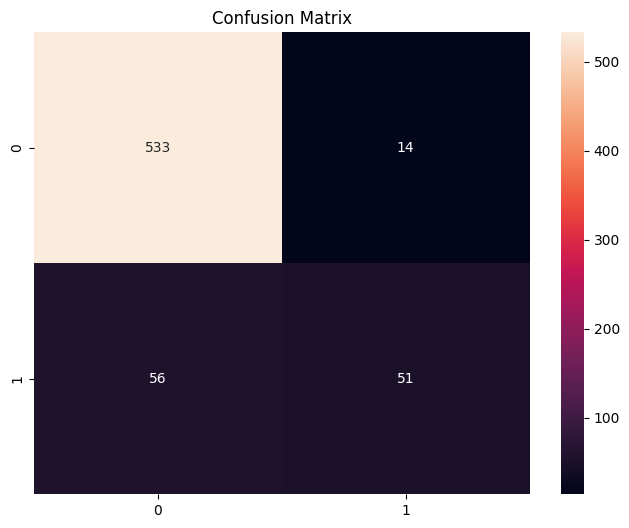

In [47]:
#Plot results of random forest classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_test = predict(rf_pipeline, X_test, 0.5)
# Print metrics
print(f"Results:")
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d')
plt.title(f'Confusion Matrix')
plt.show()


#  K-NN Classification


In [48]:
df_churn.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,3.0,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


In [50]:
df_churn['Churn'].value_counts()

,count
Churn,
0,2736
1,534


In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

In [52]:
preprocessor = create_preprocessing_pipeline()
# Create a pipeline with the preprocessor and the KNN classifier
pipeline_knn = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', KNeighborsClassifier())])

In [53]:
%%time
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2],

}

knn_gridcv = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    scoring='recall',
    cv=5,
    n_jobs=-1
)
knn_gridcv.fit(X_train, y_train)

CPU times: user 425 ms, sys: 37.3 ms, total: 462 ms
Wall time: 14.7 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Tenure',
                                                                          'WarehouseToHome',
                                                                          'NumberOfDeviceRegistered',
                                                                          'SatisfactionScore',
                                                                          'NumberOfAddress',
                                                                          'Complain',
                                                                          'DaySinceLastOrder',
                                                                          'CashbackAmount']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['PreferedOrderCat',
                                                                          'MaritalStatus'])])),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': [3, 5, 7, 9, 11],
                         'classifier__p': [1, 2],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='recall')

In [54]:
# Display the results of GridSearchCV
cv_result_knn = pd.DataFrame(knn_gridcv.cv_results_)
retain_cols_knn = ['params','mean_test_score','rank_test_score']
display(cv_result_knn[retain_cols_knn].sort_values('rank_test_score'))

,params,mean_test_score,rank_test_score
1,"{'classifier__n_neighbors': 3, 'classifier__p'...",0.477620,1
3,"{'classifier__n_neighbors': 3, 'classifier__p'...",0.456580,2
5,"{'classifier__n_neighbors': 5, 'classifier__p'...",0.433297,3
0,"{'classifier__n_neighbors': 3, 'classifier__p'...",0.433187,4
2,"{'classifier__n_neighbors': 3, 'classifier__p'...",0.430807,5
9,"{'classifier__n_neighbors': 7, 'classifier__p'...",0.405171,6
7,"{'classifier__n_neighbors': 5, 'classifier__p'...",0.402873,7
13,"{'classifier__n_neighbors': 9, 'classifier__p'...",0.379480,8
4,"{'classifier__n_neighbors': 5, 'classifier__p'...",0.379425,9
6,"{'classifier__n_neighbors': 5, 'classifier__p'...",0.365390,10


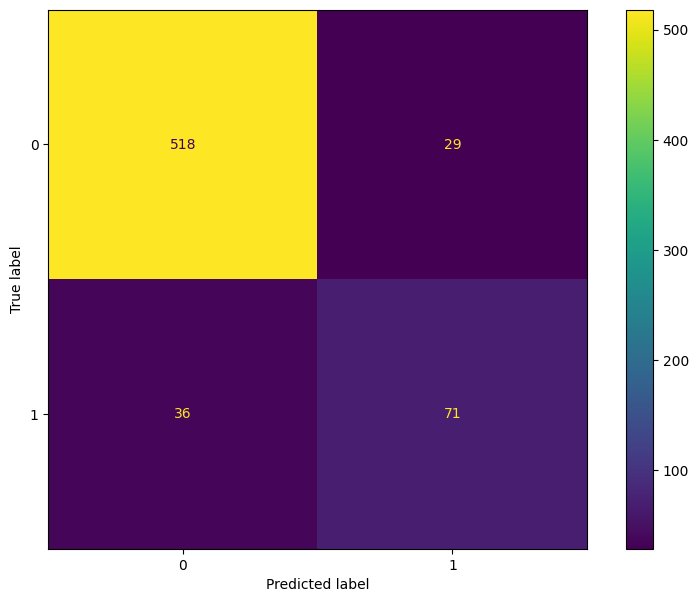

In [55]:
# plotting confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_pred = knn_gridcv.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=knn_gridcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=knn_gridcv.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

In [56]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix
import pandas as pd

def comprehensive_model_evaluation(model, X_test, y_test, model_name="Model"):
  """Complete evaluation with business context"""
  # Predictions
  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)[:, 1]
  print(f"{'='*50}")
  print(f"{model_name} EVALUATION RESULTS")
  print(f"{'='*50}")

 # 1. Classification Report
  print("\n1. CLASSIFICATION METRICS:")
  print(classification_report(y_test, y_pred))

# 2. ROC-AUC Score
  roc_auc = roc_auc_score(y_test, y_prob)
  print(f"\n2. ROC-AUC SCORE: {roc_auc:.4f}")

# 3. Precision-Recall AUC
  precision, recall, _ = precision_recall_curve(y_test, y_prob)
  pr_auc = auc(recall, precision)
  print(f"3. PR-AUC SCORE: {pr_auc:.4f}")

  # 4. Confusion Matrix Analysis
  cm = confusion_matrix(y_test, y_pred)
  tn,fp, fn, tp = cm.ravel()

  print(f"\n4. CONFUSION MATRIX BREAKDOWN:")
  print(f"  True Positives (TP): {tp}")
  print(f"  True Negatives (TN): {tn}")
  print(f"  False Positives (FP): {fp}")
  print(f"  False Negatives (FN): {fn}")

  # 5. Business Impact Calculation
  retention_cost_per_customer = 50 # Cost to run retention campaign
  customer_ltv = 500 # Customer lifetime value

  retention_campaign_cost = (tp + fp) * retention_cost_per_customer
  revenue_saved = tp * customer_ltv
  revenue_lost = fn * customer_ltv
  net_business_impact = revenue_saved - retention_campaign_cost

  print(f"\n5. BUSINESS IMPACT ANALYSIS:")
  print(f" Retention campaign cost: ${retention_campaign_cost:,}")
  print(f" Revenue saved (correctly identified churners): ${revenue_saved:,}")
  print(f" Revenue lost (missed churners): ${revenue_lost:,}")
  print(f" Net business impact: ${net_business_impact:,}")
  print(f" ROI: {(net_business_impact/retention_campaign_cost)*100:.1f}%")

  # 6. Feature Importance (if available)
  if hasattr(model, 'feature_importances_'):
    feature_imp = pd.DataFrame({
      'feature': X_test.columns,
      'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\n6. TOP 10 FEATURE IMPORTANCE:")
    for i, (_, row) in enumerate(feature_imp.head(10).iterrows()):
      print(f" {i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")
  return {
  'roc_auc': roc_auc,
  'pr_auc': pr_auc,
  'net_impact': net_business_impact,
  'confusion_matrix': cm
}

In [57]:
# KNN tuned with GridSearchCV
classification_report_knn = comprehensive_model_evaluation(
    knn_gridcv.best_estimator_, X_test, y_test, model_name="KNN"
)
print(classification_report_knn)

KNN EVALUATION RESULTS

1. CLASSIFICATION METRICS:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       547
           1       0.71      0.66      0.69       107

    accuracy                           0.90       654
   macro avg       0.82      0.81      0.81       654
weighted avg       0.90      0.90      0.90       654


2. ROC-AUC SCORE: 0.8666
3. PR-AUC SCORE: 0.6863

4. CONFUSION MATRIX BREAKDOWN:
  True Positives (TP): 71
  True Negatives (TN): 518
  False Positives (FP): 29
  False Negatives (FN): 36

5. BUSINESS IMPACT ANALYSIS:
 Retention campaign cost: $5,000
 Revenue saved (correctly identified churners): $35,500
 Revenue lost (missed churners): $18,000
 Net business impact: $30,500
 ROI: 610.0%
{'roc_auc': np.float64(0.8666131319516821), 'pr_auc': np.float64(0.6863059291171217), 'net_impact': np.int64(30500), 'confusion_matrix': array([[518,  29],
       [ 36,  71]])}


# SVM

In [58]:
df_churn.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,3.0,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


In [59]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

In [60]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, fbeta_score

preprocessor = create_preprocessing_pipeline()

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, class_weight='balanced', random_state=42)),
])


param_distributions = {
    'classifier__kernel': ['rbf', 'linear'],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
}

scorer = 'balanced_accuracy'

svm_randomcv = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

svm_randomcv.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['Tenure',
                                                                                'WarehouseToHome',
                                                                                'NumberOfDeviceRegistered',
                                                                                'SatisfactionScore',
                                                                                'NumberOfAddress',
                                                                                'Complain',
                                                                                'DaySinceLastOrder',
                                                                                'CashbackAmount']),
                                                                              ('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['PreferedOrderCat',
                                                                                'MaritalStatus'])])),
                                             ('classifier',
                                              SVC(class_weight='balanced',
                                                  probability=True,
                                                  random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'classifier__C': [0.1, 1, 10, 100],
                                        'classifier__gamma': ['scale', 'auto',
                                                              0.001, 0.01, 0.1,
                                                              1],
                                        'classifier__kernel': ['rbf',
                                                               'linear']},
                   random_state=42, scoring='balanced_accuracy', verbose=1)

In [61]:
# results of GridSearchCV
cv_result = pd.DataFrame(svm_randomcv.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
display(cv_result[retain_cols].sort_values('rank_test_score'))

,params,mean_test_score,rank_test_score
6,"{'classifier__kernel': 'rbf', 'classifier__gam...",0.793102,1
4,"{'classifier__kernel': 'rbf', 'classifier__gam...",0.787177,2
2,"{'classifier__kernel': 'rbf', 'classifier__gam...",0.785371,3
0,"{'classifier__kernel': 'linear', 'classifier__...",0.772966,4
9,"{'classifier__kernel': 'linear', 'classifier__...",0.772966,4
5,"{'classifier__kernel': 'linear', 'classifier__...",0.772738,6
3,"{'classifier__kernel': 'linear', 'classifier__...",0.772738,6
7,"{'classifier__kernel': 'linear', 'classifier__...",0.768939,8
1,"{'classifier__kernel': 'rbf', 'classifier__gam...",0.767208,9
8,"{'classifier__kernel': 'rbf', 'classifier__gam...",0.632000,10


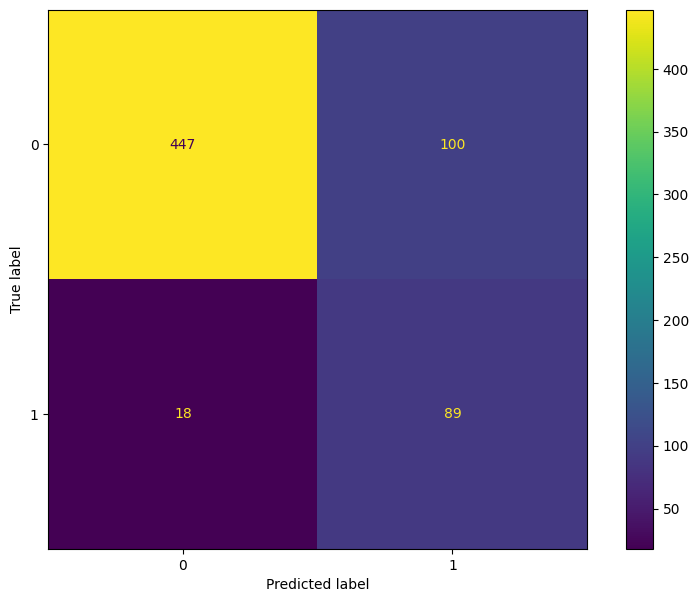

In [62]:
# the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_pred = svm_randomcv.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=svm_randomcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=svm_randomcv.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

In [63]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix
import pandas as pd

def comprehensive_model_evaluation(model, X_test, y_test, model_name="Model"):
  """Complete evaluation with business context"""
  # Predictions
  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)[:, 1]
  print(f"{'='*50}")
  print(f"{model_name} EVALUATION RESULTS")
  print(f"{'='*50}")

 # 1. Classification Report
  print("\n1. CLASSIFICATION METRICS:")
  print(classification_report(y_test, y_pred))

# 2. ROC-AUC Score
  roc_auc = roc_auc_score(y_test, y_prob)
  print(f"\n2. ROC-AUC SCORE: {roc_auc:.4f}")

# 3. Precision-Recall AUC
  precision, recall, _ = precision_recall_curve(y_test, y_prob)
  pr_auc = auc(recall, precision)
  print(f"3. PR-AUC SCORE: {pr_auc:.4f}")

  # 4. Confusion Matrix Analysis
  cm = confusion_matrix(y_test, y_pred)
  tn,fp, fn, tp = cm.ravel()

  print(f"\n4. CONFUSION MATRIX BREAKDOWN:")
  print(f"  True Positives (TP): {tp}")
  print(f"  True Negatives (TN): {tn}")
  print(f"  False Positives (FP): {fp}")
  print(f"  False Negatives (FN): {fn}")

  # 5. Business Impact Calculation
  retention_cost_per_customer = 50 # Cost to run retention campaign
  customer_ltv = 500 # Customer lifetime value

  retention_campaign_cost = (tp + fp) * retention_cost_per_customer
  revenue_saved = tp * customer_ltv
  revenue_lost = fn * customer_ltv
  net_business_impact = revenue_saved - retention_campaign_cost

  print(f"\n5. BUSINESS IMPACT ANALYSIS:")
  print(f" Retention campaign cost: ${retention_campaign_cost:,}")
  print(f" Revenue saved (correctly identified churners): ${revenue_saved:,}")
  print(f" Revenue lost (missed churners): ${revenue_lost:,}")
  print(f" Net business impact: ${net_business_impact:,}")
  print(f" ROI: {(net_business_impact/retention_campaign_cost)*100:.1f}%")

  # 6. Feature Importance (if available)
  if hasattr(model, 'feature_importances_'):
    feature_imp = pd.DataFrame({
      'feature': X_test.columns,
      'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\n6. TOP 10 FEATURE IMPORTANCE:")
    for i, (_, row) in enumerate(feature_imp.head(10).iterrows()):
      print(f" {i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")
  return {
  'roc_auc': roc_auc,
  'pr_auc': pr_auc,
  'net_impact': net_business_impact,
  'confusion_matrix': cm
}

In [65]:
classification_report_svc = comprehensive_model_evaluation(
    svm_randomcv.best_estimator_, X_test, y_test, model_name="SVC"
)
print(classification_report_svc)

SVC EVALUATION RESULTS

1. CLASSIFICATION METRICS:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88       547
           1       0.47      0.83      0.60       107

    accuracy                           0.82       654
   macro avg       0.72      0.82      0.74       654
weighted avg       0.88      0.82      0.84       654


2. ROC-AUC SCORE: 0.9119
3. PR-AUC SCORE: 0.6533

4. CONFUSION MATRIX BREAKDOWN:
  True Positives (TP): 89
  True Negatives (TN): 447
  False Positives (FP): 100
  False Negatives (FN): 18

5. BUSINESS IMPACT ANALYSIS:
 Retention campaign cost: $9,450
 Revenue saved (correctly identified churners): $44,500
 Revenue lost (missed churners): $9,000
 Net business impact: $35,050
 ROI: 370.9%
{'roc_auc': np.float64(0.9119240034854517), 'pr_auc': np.float64(0.6533289640760019), 'net_impact': np.int64(35050), 'confusion_matrix': array([[447, 100],
       [ 18,  89]])}


# XGBoost

In [66]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.6 MB/s eta 0:00:00


In [67]:
import xgboost as xgb
import optuna
from sklearn.metrics import make_scorer

In [69]:
def create_xgb_pipeline(hyperparams):
    preprocessor = create_preprocessing_pipeline()
    classifier = xgb.XGBClassifier(**hyperparams,
                                   scale_pos_weight=n_negatives/n_positives,
                                   random_state=42)
    xgb_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
    return xgb_pipeline

hyperparams = {"n_estimators": 50, "max_depth": 15, "subsample": 0.2, "eta": 0.1}
xgb_pipeline = create_xgb_pipeline(hyperparams)


xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'Complain',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('classifier',
                 XGBCl...
                               eval_metric=None, feature_types=None,
                               feature_weights=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=15, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None, ...))])

In [70]:
# Estimate probability on train and test dataset
train_probs = xgb_pipeline.predict_proba(X_train)
test_probs = xgb_pipeline.predict_proba(X_test)

# Print train and test loss
train_loss = log_loss(y_train, train_probs)
test_loss = log_loss(y_test, test_probs)
print(f"Train loss: {train_loss}")
print(f"Test loss: {test_loss}")

Train loss: 0.16982797602366598
Test loss: 0.24172975962024829


Results:
Test Accuracy: 0.9097859327217125

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       547
           1       0.70      0.79      0.74       107

    accuracy                           0.91       654
   macro avg       0.83      0.86      0.84       654
weighted avg       0.91      0.91      0.91       654



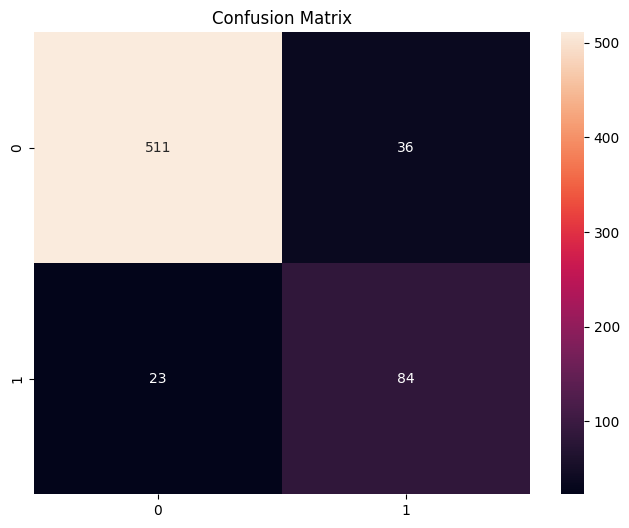

In [71]:
# Plot results of XGBoost classifier
# Get predictions using the pipeline's predict method
y_pred_test = xgb_pipeline.predict(X_test)

# Print metrics
print(f"Results:")
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d')
plt.title(f'Confusion Matrix')
plt.show()


In [72]:
def objective(trial):
    xgb_params = {
        'max_depth': trial.suggest_int('max_depth', 10, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.2, 0.5),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1, 5)
    }

    xgb_pipeline = create_xgb_pipeline(xgb_params)
    # Use cross-validation score as our metric
    score = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='precision').mean()
    return score

In [73]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-08-22 03:37:23,974] A new study created in memory with name: no-name-74c33152-e44c-4634-ae28-d1c44c828b2c
[I 2025-08-22 03:37:24,345] Trial 0 finished with value: 0.5302771440337803 and parameters: {'max_depth': 14, 'learning_rate': 0.2507837607783176, 'n_estimators': 99, 'min_child_weight': 5, 'subsample': 0.28571935670695187, 'colsample_bytree': 0.6328114537478982, 'gamma': 3.2758654181641345}. Best is trial 0 with value: 0.5302771440337803.
[I 2025-08-22 03:37:24,682] Trial 1 finished with value: 0.521927441636744 and parameters: {'max_depth': 14, 'learning_rate': 0.19164566440681824, 'n_estimators': 78, 'min_child_weight': 3, 'subsample': 0.25874509702088005, 'colsample_bytree': 0.7081999538385265, 'gamma': 4.1441016700632325}. Best is trial 0 with value: 0.5302771440337803.
[I 2025-08-22 03:37:24,968] Trial 2 finished with value: 0.49302218960790983 and parameters: {'max_depth': 11, 'learning_rate': 0.43591170510399735, 'n_estimators': 52, 'min_child_weight': 6, 'subsample

Best trial:
  Value:  0.6618911154571278
  Params: 
    max_depth: 12
    learning_rate: 0.1002345155636347
    n_estimators: 69
    min_child_weight: 1
    subsample: 0.49079581838374897
    colsample_bytree: 0.9310906726723165
    gamma: 1.010270551087399



XGBoost Results:
Accuracy: 0.9113149847094801

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       547
           1       0.68      0.87      0.76       107

    accuracy                           0.91       654
   macro avg       0.83      0.89      0.85       654
weighted avg       0.92      0.91      0.92       654



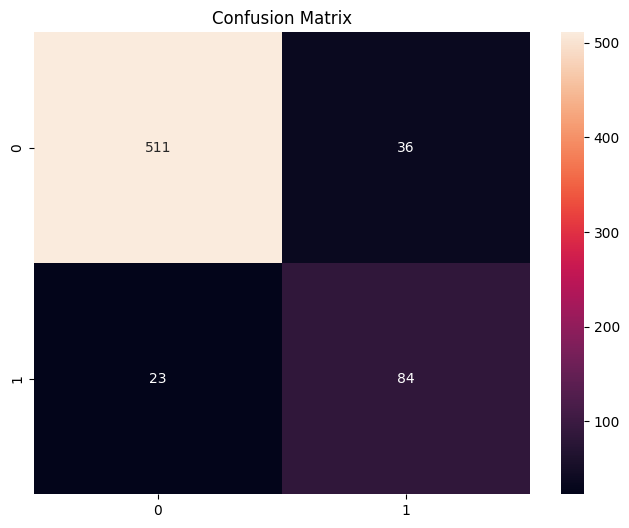

In [75]:
#Train XGBoost with best parameters
best_params = study.best_params
xgb_model = create_xgb_pipeline(best_params)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_test)

print("\nXGBoost Results:")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d')
plt.title(f'Confusion Matrix')
plt.show()

# Stacking

In [76]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [77]:

preprocessor = create_preprocessing_pipeline()

pos = int(y_train.sum())
neg = int((y_train == 0).sum())
spw = neg / max(pos, 1)

base_estimators = [
    ("rf",  RandomForestClassifier(
        n_estimators=300, class_weight="balanced_subsample",
        n_jobs=-1, random_state=42
    )),
    ("svm", SVC(
        kernel="rbf", probability=True, class_weight="balanced",
        random_state=42
    )),
    ("knn", KNeighborsClassifier(
        n_neighbors=5, weights="distance"
    )),
    ("xgb", XGBClassifier(
        n_estimators=300, learning_rate=0.1, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, tree_method="hist",
        eval_metric="logloss", scale_pos_weight=spw,
        n_jobs=-1, random_state=42
    )),
]

stack_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=1000, class_weight="balanced"),
    stack_method="predict_proba",
    cv=5,
    n_jobs=-1,
    passthrough=False
)

stack_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("stack", stack_clf),
])

stack_pipe.fit(X_train, y_train)
comprehensive_model_evaluation(stack_pipe, X_test, y_test, "Stacking (RF+SVM+KNN+XGB)")


Stacking (RF+SVM+KNN+XGB) EVALUATION RESULTS

1. CLASSIFICATION METRICS:
              precision    recall  f1-score   support

           0       0.99      0.89      0.93       547
           1       0.62      0.93      0.74       107

    accuracy                           0.89       654
   macro avg       0.80      0.91      0.84       654
weighted avg       0.93      0.89      0.90       654


2. ROC-AUC SCORE: 0.9592
3. PR-AUC SCORE: 0.7429

4. CONFUSION MATRIX BREAKDOWN:
  True Positives (TP): 100
  True Negatives (TN): 485
  False Positives (FP): 62
  False Negatives (FN): 7

5. BUSINESS IMPACT ANALYSIS:
 Retention campaign cost: $8,100
 Revenue saved (correctly identified churners): $50,000
 Revenue lost (missed churners): $3,500
 Net business impact: $41,900
 ROI: 517.3%


{'roc_auc': np.float64(0.9591997129628047),
 'pr_auc': np.float64(0.7428548936857731),
 'net_impact': np.int64(41900),
 'confusion_matrix': array([[485,  62],
        [  7, 100]])}

# Comparison Table

In [78]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc, confusion_matrix
)

LTV  = 500   # customer lifetime value
COST = 50    # retention cost per contacted customer

def _proba(m, X):
    if hasattr(m, "predict_proba"):
        return m.predict_proba(X)[:, 1]
    if hasattr(m, "decision_function"):
        s = m.decision_function(X)
        return (s - s.min()) / (s.max() - s.min() + 1e-12)
    return m.predict(X).astype(float)

def evaluate(model, X, y, name):
    p = _proba(model, X)
    yhat = (p >= 0.5).astype(int)

    acc  = accuracy_score(y, yhat)
    prec = precision_score(y, yhat, zero_division=0)
    rec  = recall_score(y, yhat, zero_division=0)
    f1   = f1_score(y, yhat, zero_division=0)

    try:
        roc = roc_auc_score(y, p)
    except ValueError:
        roc = np.nan
    pr_p, pr_r, _ = precision_recall_curve(y, p)
    pr_auc = auc(pr_r, pr_p)

    # profit-based threshold search
    best = {"thr": 0.5, "net": -1e18, "cm": (0,0,0,0)}
    for t in np.linspace(0.05, 0.95, 91):
        pred = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
        net = tp*LTV - (tp+fp)*COST
        if net > best["net"]:
            best = {"thr": float(t), "net": int(net), "cm": (tn, fp, fn, tp)}
    tn, fp, fn, tp = best["cm"]
    camp_cost = (tp + fp) * COST
    roi = (best["net"] / camp_cost) if camp_cost > 0 else np.nan

    return {
        "Model": name,
        "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1,
        "ROC-AUC": roc, "PR-AUC": pr_auc,
        "Best_Threshold": best["thr"], "Net_Impact_$": best["net"], "ROI": roi,
        "TP": tp, "FP": fp, "FN": fn, "TN": tn
    }

def _pick_estimator(obj):
    return getattr(obj, "best_estimator_", obj)

# Collect exactly the five models
candidates = []
for var, label in [
    ("svm_randomcv", "SVM"),
    ("knn_gridcv", "K-NN"),
    ("rf_clf_randomcv", "Random Forest"),
    ("xgb_pipeline", "XGBoost"),
    ("stack_pipe", "Stacking (RF+SVM+KNN+XGB)")
]:
    if var in globals():
        candidates.append((label, _pick_estimator(globals()[var])))

# Build the table
rows = [evaluate(m, X_test, y_test, name) for name, m in candidates]
comparison_df = pd.DataFrame(rows).set_index("Model")
comparison_df = comparison_df.sort_values(["PR-AUC", "Net_Impact_$"], ascending=False)

# Show
try:
    display(comparison_df.round(3))
except NameError:
    print(comparison_df.round(3))


,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC,Best_Threshold,Net_Impact_$,ROI,TP,FP,FN,TN
Model,,,,,,,,,,,,,
XGBoost,0.910,0.700,0.785,0.740,0.947,0.751,0.19,40700,3.602,104,122,3,425
Stacking (RF+SVM+KNN+XGB),0.894,0.617,0.935,0.743,0.959,0.743,0.47,42500,5.000,102,68,5,479
Random Forest,0.905,0.664,0.850,0.746,0.946,0.691,0.36,41150,4.650,100,77,7,470
K-NN,0.901,0.710,0.664,0.686,0.867,0.686,0.29,35050,4.148,87,82,20,465
SVM,0.881,0.679,0.514,0.585,0.912,0.653,0.11,37300,3.057,99,145,8,402
